In [1]:
import pickle
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from langchain_community.chat_models import ChatOpenAI
from langchain_experimental.agents import create_pandas_dataframe_agent

import os
os.environ['OPENAI_API_KEY'] = "key"

# Read the complete MTA/QTL marker file for the 21 manuscripts

In [2]:
df = pd.read_csv("data_input/markers/all_QTL_markers_EP.txt", sep="\t")

# Prompt the LLMs to write a nerative based on curated results

In [ ]:
response_dict = {}
for model_name in ["gpt-3.5-turbo-1106", "gpt-4"]:
    llm = ChatOpenAI(model_name=model_name)
    agent = create_pandas_dataframe_agent(llm, df, verbose=False)
    for rep in [1,2,3]:
        time.sleep(2)
        response = agent.run("""Your task is to extract information about genetic mapping results associated with particular trait QTLs. \
                                In this case, the traits should only be related to plant response to disease or disease resistance. \
                                Use the 'chr', 'start', and 'end' columns to get information about the genomic location. \
                                Write a detailed description of all the extracted traits.""")
        response_dict["{}_{}_minimal".format(model_name, rep)] = response
        time.sleep(2)
        response = agent.run("""Your task is to extract information about genetic mapping results associated with particular trait QTLs. \
                                In this case, the traits should only be related to plant response to disease or disease resistance. \
                                To do this, check the unique values in the 'trait' column and guess based on your general knowledge. \
                                Use the 'chr', 'start', and 'end' columns to get information about the genomic location. \
                                Write a detailed description of all the extracted traits.""")
        response_dict["{}_{}_instructions".format(model_name, rep)] = response

for model_name in ["gpt-3.5-turbo-1106", "gpt-4"]:
    llm = ChatOpenAI(model_name=model_name)
    agent = create_pandas_dataframe_agent(llm, df, verbose=False)
    for rep in [1,2,3]:
        time.sleep(2)
        response = agent.run("""Your task is to extract information about genetic mapping results associated with particular trait QTLs. \
                                In this case, the traits should only be related to plant response to disease or disease resistance. \
                                Use the 'chr', 'start', and 'end' columns to get information about the genomic location. \
                                Range: Include only traits with QTLs located on chromosome 2B between 50mbp and 700mbp. \
                                Write a detailed description of all the extracted traits.""")
        response_dict["{}_{}_range_minimal".format(model_name, rep)] = response
        
        time.sleep(2)
        response = agent.run("""Your task is to extract information about genetic mapping results associated with particular trait QTLs. \
                                In this case, the traits should only be related to plant response to disease or disease resistance. \
                                To do this, check the unique values in the 'trait' column and guess based on your general knowledge. \
                                Use the 'chr', 'start', and 'end' columns to get information about the genomic location. \
                                Range: Include only traits with QTLs located on chromosome 2B between 50mbp and 700mbp. \
                                Write a detailed description of all the extracted traits.""")
        response_dict["{}_{}_range_instructions".format(model_name, rep)] = response
        
with open('data_output/pickles/gpt_nerrative_results.pkl', 'wb') as handle:
    pickle.dump(response_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Plot length of nerrated responses

In [3]:
with open('data_output/pickles/gpt_nerrative_results.pkl', 'rb') as handle:
    response_dict = pickle.load(handle)

model_dict_convert = {"gpt-3.5-turbo-1106": "GPT3.5",
                      "gpt-4": "GPT4"}

# Generate the length table
response_list = []
for key, item in response_dict.items():
    range_type = "Range" if "range" in key else "Full"
    response_list.append([model_dict_convert[key.split("_")[0]],
                          key.split("_")[1],
                          len(item),
                          range_type,
                          "- Instructions" if "minimal" in key.split("_")[-1] else "+ Instructions"])
    
response_df = pd.DataFrame(response_list)
response_df.columns = ["Model", "rep", "Response Length", "Selected Range", "Prompt"]

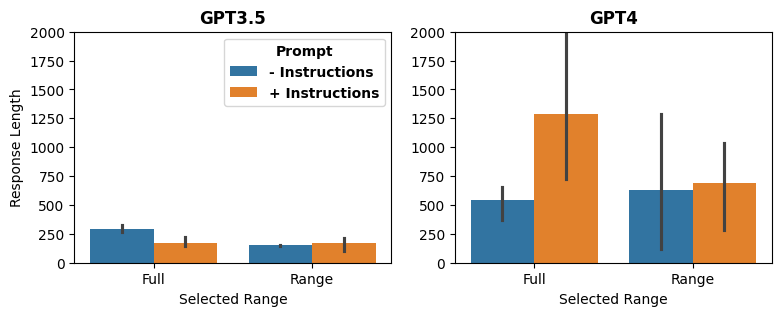

In [4]:
response_df_gpt3 = response_df[response_df["Model"]=="GPT3.5"]
response_df_gpt4 = response_df[response_df["Model"]=="GPT4"]

fig, ax = plt.subplots(1,2, figsize=(9,3), sharey=False)

plt.rcParams.update({'font.weight': 'bold', 'font.size': 10,
                     'axes.labelweight': 'bold', 'axes.titleweight': 'bold'})

ax1 = sns.barplot(data=response_df_gpt3, x="Selected Range", y="Response Length", hue="Prompt", ax=ax[0])
ax[0].set_ylim([0,2000])
ax2 = sns.barplot(data=response_df_gpt4, x="Selected Range", y="Response Length", hue="Prompt", ax=ax[1])
ax[1].set_ylim([0,2000])
ax1.set_title("GPT3.5")
ax1.set_ylabel("Response Length")
ax2.set_title("GPT4")
ax2.set_ylabel("")
ax2.get_legend().remove()
plt.show()